# Custom Dataset

In this notebook, we will see how to add your own dataset to CeBed. Since several datasets are generated using Matlab, in this tutorial, we will create a Matlab dataset using saved mat files.

As an example, we will use the datasets from the ChannelNet [repo](https://github.com/MehranSoltani94/ChannelNet). 

In [1]:
# Imports

import os
from typing import Optional, Tuple
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

from cebed.datasets.base import TensorOfflineDataset
os.environ["CUDA_VISIBLE_DEVICES"]=""

2023-05-18 10:27:37.724185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 10:27:38.812991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/user/amal.feriani/anaconda3/envs/tf/lib/
2023-05-18 10:27:38.813147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/user/amal.feriani/anaconda3/envs/tf/lib/
2023-05-18 10:27:38.813161: W tensorflow/com

### Create a single domain dataset
In this example, we will create a single domain dataset that inherits from the `TensorOfflineDataset`. The new dataset class needs to implement a method `.load_data()` to load the dataset from disk.

**Note**: We renamed the downloaded files to `inputs.mat` and `labels.mat`

In [2]:
class OfflineMatlabDataset(TensorOfflineDataset):
    """Matlab dataset"""

    def __init__(
        self,
        path: str,
        seed: int = 0,
        train_split: float = 0.9,
    ):
        super().__init__(path=path, seed=seed, train_split=train_split)

    def load_data(self):
        """
        Load matlab dataset from disk.
        """
        inputs_path = os.path.join(self.main_path, "inputs.mat")
        labels_path = os.path.join(self.main_path, "labels.mat")
        self.inputs = loadmat(inputs_path)["My_noisy_H"]
        self.labels = loadmat(labels_path)["My_perfect_H"]

In [3]:
dataset = OfflineMatlabDataset(path="./")

2023-05-18 10:27:50.948189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-18 10:27:50.948271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lambdagpu2mt
2023-05-18 10:27:50.948363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lambdagpu2mt
2023-05-18 10:27:50.948577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.74.0
2023-05-18 10:27:50.948614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.74.0
2023-05-18 10:27:50.948622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.74.0
2023-05-18 10:27:50.949193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with

In [44]:
# Utility function to plot random channels from dataset
def display_complex_channels(tensors:tf.Tensor, sample_size:int=5, mask:Optional[tf.Tensor]=None)->plt.figure:
    
    figure = plt.figure(figsize=(10, 10))
    ids = np.random.choice(len(tensors), size=sample_size, replace=False)

    if isinstance(mask, tf.Tensor):
        mask = mask.numpy()
    
    for i, idx in enumerate(ids):            
        plt.subplot(sample_size, 2, 2 * i + 1)
        sns.heatmap(tf.math.real(tensors[idx]), mask=mask)
        plt.subplot(sample_size, 2, 2 * i + 2)
        sns.heatmap(tf.math.imag(tensors[idx]), mask=mask)

    return figure

(32400, 72, 14)


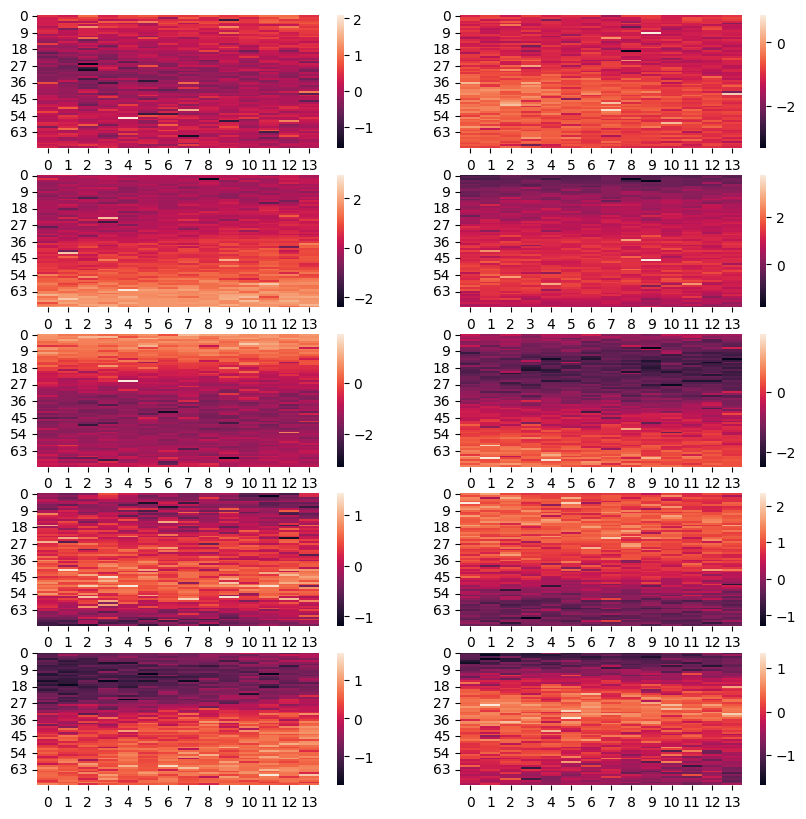

In [45]:
print(dataset.train_x.shape)
figure = display_complex_channels(dataset.train_x)
plt.show()

### Add custom preprocessing

The default preprocessing supported in `TensorOfflineDataset` class is the conversion from complex to real.

If your dataset requires additional preprocessing, you can override the `.preprocess` method. 

As an example, the inputs and the labels of the dataset we are using have the following shape `(nrof_ofdm_subcarriers, nrof_ofdm_symbols)`. 

**CeBed expects the inputs nd labels to have the following shape (nrof_ofdm_symbols, nrof_ofdm_subcarriers)**

Now, we add the preprocess method to the `OfflineMatlabDataset`. 

In [ ]:

class OfflineMatlabDataset(TensorOfflineDataset):
    """Matlab dataset"""

    def __init__(
        self,
        path: str,
        seed: int = 0,
        train_split: float = 0.9,
    ):
        super().__init__(path=path, seed=seed, train_split=train_split)

    def load_data(self):
        """
        Load matlab dataset from disk.
        """
        inputs_path = os.path.join(self.main_path, "inputs.mat")
        labels_path = os.path.join(self.main_path, "labels.mat")
        self.inputs = loadmat(inputs_path)["My_noisy_H"]
        self.labels = loadmat(labels_path)["My_perfect_H"]
    
    def preprocess(self, input: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor]:
        """Per-sample preprocess function"""

        # Permute 
        input = tf.transpose(input, [1,0])
        label = tf.transpose(label, [1,0])
        
        # convert complex to real
        return super().preprocess(input, label)

Now, we can take a look to the train and eval batches

In [ ]:
dataset = OfflineMatlabDataset(path="./")
train_loader, val_loader = dataset.get_loaders(train_batch_size=100, eval_batch_size=32)
train_inputs, train_labels = next(iter(train_loader))
print(train_labels.shape)
assert train_labels.shape == (100, 14, 72, 2)

(100, 14, 72, 2)


2023-05-17 16:08:31.701407: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Low resolution inputs

Super-resolution models such as ChannelNet expect a low-resolution inputs. Hence, we need to add one more step to our preprocessing method to transform the inputs to low resolution tensors. 

To do that, we start by defining a mask. The mask values should be 1 in pilot localtions and zero elsewhere.

<Axes: >

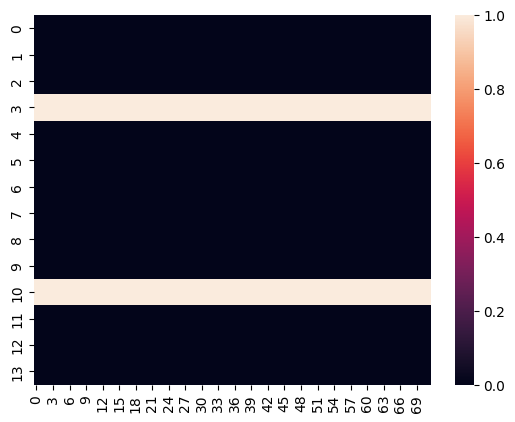

In [9]:

shape = [14, 72]
mask = np.zeros(shape, bool)

# Let's assume that the pilots are arranged in a block style
# The pilots will inserted in the 3rd and 10th symbols

pilot_symbol_indices = [3, 10]

mask[pilot_symbol_indices, :] = True

sns.heatmap(mask)

Let's incorporate this to our dataset. 

First, we will implement the method `get_mask` to define the pilot mask.

Next, we will update the `preprocess`method to produce two types of inputs :
- `low`: Low-resolution inputs
- `raw`: masked inputs

In [29]:

class OfflineMatlabDataset(TensorOfflineDataset):
    """Matlab dataset"""

    def __init__(
        self,
        path: str,
        seed: int = 0,
        train_split: float = 0.9,
        input_type: str = "raw",
    ):
        super().__init__(path=path, seed=seed, train_split=train_split, input_type=input_type)
        self.mask = self.get_mask()

    def get_mask(self):
        shape = [14, 72]
        mask = np.zeros(shape, bool)

        # Let's assume that the pilots are arranged in a block style
        # The pilots will inserted in the 3rd and 10th symbols

        pilot_symbol_indices = [3, 10]

        mask[pilot_symbol_indices, :] = True

        return tf.cast(mask, tf.float32)
    
    def load_data(self):
        """
        Load matlab dataset from disk.
        """
        inputs_path = os.path.join(self.main_path, "inputs.mat")
        labels_path = os.path.join(self.main_path, "labels.mat")
        self.inputs = loadmat(inputs_path)["My_noisy_H"]
        self.labels = loadmat(labels_path)["My_perfect_H"]
    
    def preprocess(self, input: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor]:
        """Per-sample preprocess function"""

        # Permute 
        input = tf.transpose(input, [1,0])
        label = tf.transpose(label, [1,0])

        input = tf.cast(input, tf.complex64)
        label = tf.cast(label, tf.complex64)

        # transform the input according to the input type
        if self.input_type=="raw":
            input = input*tf.complex(self.mask, self.mask)
        elif self.input_type =="low":
            pilot_indices = tf.where(self.mask)
            # gather the pilot symbols
            symbol_indices, _ = tf.unique(pilot_indices[:, -2])
            input = tf.gather(indices=symbol_indices, params=input, axis=0)
            # gather the pilot subcarriers
            subc_indices, _ = tf.unique(pilot_indices[:, -1])
            input = tf.gather(indices=subc_indices, params=input, axis=1)
        else:
            raise ValueError(f"Unrecognized input type {self.input_type}")
        
        # convert complex to real
        return super().preprocess(input, label)

In [5]:
dataset = OfflineMatlabDataset(path="./", input_type="low")
train_loader, val_loader = dataset.get_loaders(train_batch_size=100, eval_batch_size=32)
train_inputs, train_labels = next(iter(train_loader))
assert train_labels.shape == (100, 14, 72, 2)
assert train_inputs.shape == (100, 2, 72, 2)

Tensor("Unique:0", shape=(None,), dtype=int64)
Tensor("Unique_1:0", shape=(None,), dtype=int64)
Tensor("Unique:0", shape=(None,), dtype=int64)
Tensor("Unique_1:0", shape=(None,), dtype=int64)


2023-05-18 10:28:23.599037: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [30]:
dataset = OfflineMatlabDataset(path="./", input_type="raw")
train_loader, val_loader = dataset.get_loaders(train_batch_size=100, eval_batch_size=32)
train_inputs, train_labels = next(iter(train_loader))
assert train_labels.shape == (100, 14, 72, 2)
assert train_inputs.shape == (100, 14, 72, 2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-05-18 10:53:52.157147: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


<Axes: >

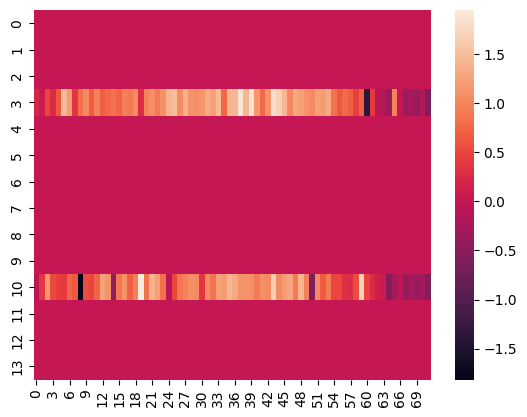

In [49]:
# You can visualize the training inputs as follows
sns.heatmap(train_inputs[0,:,:,1])

## Integrate your dataset to CeBed

1- Start by adding your dataset class to the `datasets` module
2- Register your dataset to the list of CeBed datasets in `datasets/__init__.py` 
```python
DATASETS = {
    "SionnaOfflineMD": MultiDomainOfflineSionnaDataset,
    "SionnaOffline": OfflineSionnaDataset,
    "MyCustomDataset": OfflineMatlabDataset, 
}
```
3- Run the benchmarking using your dataset
```python
python scripts/benchmark.py --seed SEED --data_dir DATADIR --experiment_name EXPERIMENT_NAME --dataset_name MyCustomDataset 
```